# **In Plane Sight: Scanline Encoders**

---
Joseph Mills

MRes Advanced Artificial Intelligence

University of Sussex

---


### **ZZZ. Import Libraries and dependencies**
*Note: Google Colab has been used for this project and all dependencies to ensure reproducibility given current difficulties with initialisation of pyGENN/mlGENN*

In [ ]:
# Initialise Colab

if "google.colab" in str(get_ipython()):
    !gdown 1OJH0FAR4GRsvIKkHw0NBM-9aYU2VJ1bo
    !pip install pygenn-5.1.0-cp310-cp310-linux_x86_64.whl # pygenn 5.1.0
    %env CUDA_PATH=/usr/local/cuda

    !rm -rf /content/ml_genn-ml_genn_2_3_0
    !wget https://github.com/genn-team/ml_genn/archive/refs/tags/ml_genn_2_3_0.zip # mlgenn 2.3.0
    !unzip -q ml_genn_2_3_0.zip
    !pip install ./ml_genn-ml_genn_2_3_0/ml_genn

Downloading...
From: https://drive.google.com/uc?id=1OJH0FAR4GRsvIKkHw0NBM-9aYU2VJ1bo
To: /content/pygenn-5.1.0-cp310-cp310-linux_x86_64.whl
100% 8.47M/8.47M [00:00<00:00, 90.4MB/s]
Processing ./pygenn-5.1.0-cp310-cp310-linux_x86_64.whl
pygenn is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
env: CUDA_PATH=/usr/local/cuda
--2025-01-15 07:38:09--  https://github.com/genn-team/ml_genn/archive/refs/tags/ml_genn_2_3_0.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/genn-team/ml_genn/zip/refs/tags/ml_genn_2_3_0 [following]
--2025-01-15 07:38:09--  https://codeload.github.com/genn-team/ml_genn/zip/refs/tags/ml_genn_2_3_0
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.20

In [ ]:
!pip install bresenham


In [ ]:
# Initialise Packages
# *** Making sure possible to explicitly import MNIST CIFAR10 etc.


import torch; torch.manual_seed(0)
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import numpy as np
import matplotlib.pyplot as plt
from ml_genn import InputLayer, Layer, SequentialNetwork
from ml_genn.callbacks import Checkpoint
from ml_genn.compilers import EPropCompiler, InferenceCompiler
from ml_genn.connectivity import Dense,FixedProbability
from ml_genn.initializers import Normal
from ml_genn.neurons import LeakyIntegrate, LeakyIntegrateFire, SpikeInput
from ml_genn.serialisers import Numpy
from ml_genn.utils.data import (calc_latest_spike_time, log_latency_encode_data)
from ml_genn.compilers.eprop_compiler import default_params
from bresenham import bresenham



In [ ]:
# GPU used for this notebook - Collab using T4, L4 and maybe A100
!nvidia-smi

Wed Jan 15 07:32:13 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              48W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Install MNIST package

In [ ]:
!pip install mnist cifar10
import cifar10
import mnist
mnist.datasets_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"
mnist_train = mnist.train_images()
mnist_test = mnist.test_images()
mnist_train_y = mnist.train_labels()
mnist_test_y = mnist.test_labels()


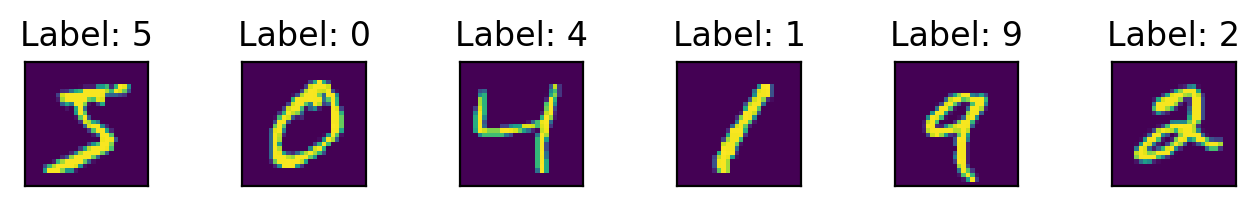

In [ ]:
for i in range(6):
  plt.subplot(1,6,i+1)
  plt.tight_layout()
  plt.imshow(mnist_train[i], cmap='viridis', interpolation='none')
  plt.title("Label: {}".format(mnist_train_y[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

## Latency encoding
There are numerous ways to encode images using spikes but here we are going to emit a single spike for each neuron at a time calculated as follows from the pixel grayscale $x$:
\begin{align}
    T(x) = \begin{cases}
        \tau_\text{eff} \log\left(\frac{x}{x-\theta}  \right) & x > \theta\\
        \infty & otherwise\\
    \end{cases}
\end{align}
where $\tau_\text{eff}=20\text{ms}$ and $\theta=51$.

### _From ml_genn - explicitly stating here to align Scanline_

In [ ]:
from typing import List, Sequence

from collections import namedtuple

PreprocessedSpikes = namedtuple("PreprocessedSpikes", ["end_spikes", "spike_times"])


def log_latency_encode_data(data: np.ndarray, tau_eff: float,
                            thresh: float) -> List[PreprocessedSpikes]:
    """Generate PreprocessedSpikes format stimuli by log-latency
    encoding static data

    .. math::

        T(x)= \\begin{cases}
                  \\tau_\\text{eff} log\\left(\\frac{x}{x - \\nu}\\right) & x > \\nu \\\\
                  \\infty & otherwise
              \\end{cases}

    Args:
        data:       Data in uint8 format
        tau_eff:    Scaling factor
        thresh:     Threshold values must reach for any spike to be emitted
    """
    # Loop through examples
    spikes = []
    for i in range(len(data)):
        # Get boolean mask of spiking neurons
        spike_vector = data[i] > thresh

        # Take cumulative sum to get end spikes
        end_spikes = np.cumsum(spike_vector)

        # Extract values of spiking pixels
        spike_pixels = data[i, spike_vector]

        # Calculate spike times
        spike_times = tau_eff * np.log(spike_pixels / (spike_pixels - thresh))

        # Add to list
        spikes.append(PreprocessedSpikes(end_spikes, spike_times))

    return spikes

In [ ]:
#spike_vector = mnist_train[0] > 51
#end_spikes = np.cumsum(spike_vector)
#end_spikes

In [ ]:
train_spikes = log_latency_encode_data(mnist_train, 20.0, 51)

In [ ]:
#train_spikes[1][1]

## ScanLine Encoding
Taking inspiration from github page https://github.com/BCGardner/snn-classifier and paper


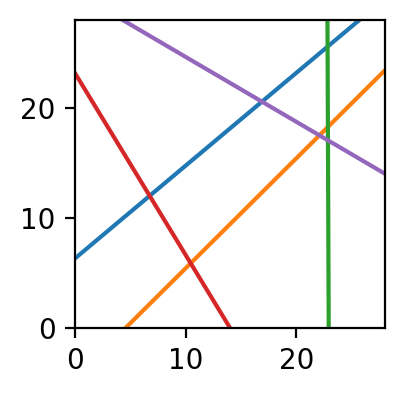

In [ ]:
# Matched to Intel's Loihi encoder.
line_eqs_loihi = [(0.844, 6.27), (1.00, -4.62), (-250., 5733.),
                  (-1.654, 23.156), (-0.59, 30.509)]

plt.figure(figsize=(2,2))
for m,c in line_eqs_loihi:
  x = np.linspace(0, 28, 10)
  y = (m * x) + c


  # Create the plot


  plt.plot(x, y)
  plt.xlim(0,28)
  plt.ylim(0,28)

plt.show() ## REMEMBER IT IS INVERTED...

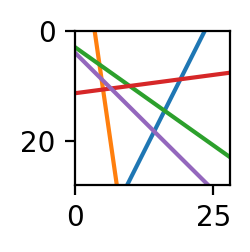

In [ ]:
#random line equations # for possible later execution

import random

def rand_scans(randseeds):
  rand_list_x=[]
  rand_list_y=[]

  rand_list_x2=[]
  rand_list_y2=[]
  dy_dx = []
  intercept = []

  random.seed(randseeds)
  n=5 # same as loio
  plt.figure(figsize=(1,1))
  for i in range(n):
      rand_list_x.append(random.randint(3,25))
      rand_list_y.append(random.randint(3,25))

      rand_list_x2.append(random.randint(3,25))
      rand_list_y2.append(random.randint(3,25))

      dy_dx.append((rand_list_y2[i]-rand_list_y[i])/(rand_list_x2[i]-rand_list_x[i]))
      intercept.append(-rand_list_x[i]*dy_dx[i] + rand_list_y[i])
      # Creating vectors X and Y
      x = np.linspace(0, 28, 4)
      y = (dy_dx[i] * x ) + intercept[i]


      # Create the plot


      plt.plot(x, y)
      plt.xlim(0,28)
      plt.ylim(0,28)
      plt.gca().invert_yaxis()


plt.show()
rand_scans(6)

In [ ]:
def gen_rand_scans(number_of_scans):

  rand_list_x=[]
  rand_list_y=[]
  rand_list_x2=[]
  rand_list_y2=[]
  dy_dx = []
  intercept = []
  rand_eqs = []

  np.random.seed(42)

  for i in range(number_of_scans):
      rand_list_x.append(np.random.uniform(7,21))
      #print(rand_list_x)
      rand_list_y.append(np.random.uniform(7,21))

      rand_list_x2.append(np.random.uniform(7,21))
      rand_list_y2.append(np.random.uniform(7,21))

      dy_dx.append((rand_list_y2[i]-rand_list_y[i])/(rand_list_x2[i]-rand_list_x[i]))
      intercept.append(-rand_list_x[i]*dy_dx[i] + rand_list_y[i])

      rand_eqs.append((dy_dx[i], intercept[i]))

  return rand_eqs

rand5_eqs = gen_rand_scans(5)
rand10_eqs = gen_rand_scans(10)
rand15_eqs = gen_rand_scans(15)
rand20_eqs = gen_rand_scans(20)
rand50_eqs = gen_rand_scans(50)


In [ ]:
rand10_eqs

[(-0.9848987466229837, 32.368668826678785),
 (-7.251558895251311, 75.78413259042114),
 (-0.45103102506522424, 23.86593454360208),
 (0.04447250973838177, 9.143148593032219),
 (-1.8286782741093934, 34.93639447834694),
 (-0.7096094184221899, 19.99865205305825),
 (1.05672986106634, 3.848155637223062),
 (8.200356242129319, -117.76433502457205),
 (-0.15599738000410557, 21.518449474566562),
 (0.9021680884528347, -1.7951465290022082)]

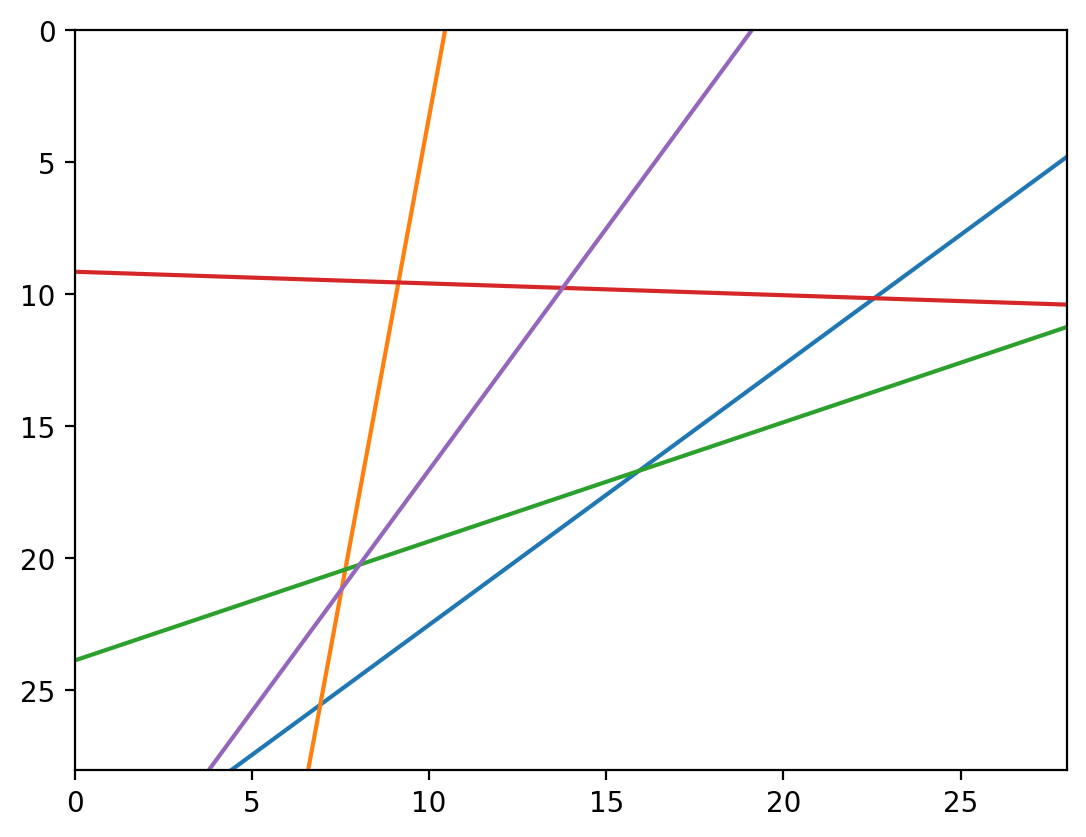

In [ ]:
for m,c in rand5_eqs:
  x = np.linspace(0, 28, 10)
  y = (m * x) + c


  # Create the plot


  plt.plot(x, y)
  plt.xlim(0,28)
  plt.ylim(0,28)
  plt.gca().invert_yaxis()
plt.show()

In [ ]:
def find_fired_pixels_bres(line_eqs, x_range, y_range):
    fired_pixels = []
    for idx, (m, c) in enumerate(line_eqs):
        x=x_range[0]
        x2=x_range[1]
        y=int(m*y_range[0]+c)
        y2=int(m*y_range[1]+c)

        list(bresenham(x,y,x2,y2))
        for x,y in list(bresenham(x,y,x2,y2)):
          if 0 <= x < 28 and 0 <= y < 28 :
            fired_pixels.append([idx,x,y])


    return fired_pixels



In [ ]:
def find_fired_pixels_adj(line_eqs, x_range, y_range):
    fired_pixels = []
    for idx,(m, c) in enumerate(line_eqs):
        x=x_range[0]
        x2=x_range[1]
        y=int(m*y_range[0]+c)
        y2=int(m*y_range[1]+c)

        list(bresenham(x,y,x2,y2))
        for x,y in list(bresenham(x,y,x2,y2)):
          if 0 <= x < 28 and 0 <= y < 28 :
            fired_pixels.append([idx,x,y])
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0:  # Skip the center pixel itself
                        continue
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < 28 and 0 <= ny < 28:
                        fired_pixels.append([idx,nx, ny])
    return fired_pixels

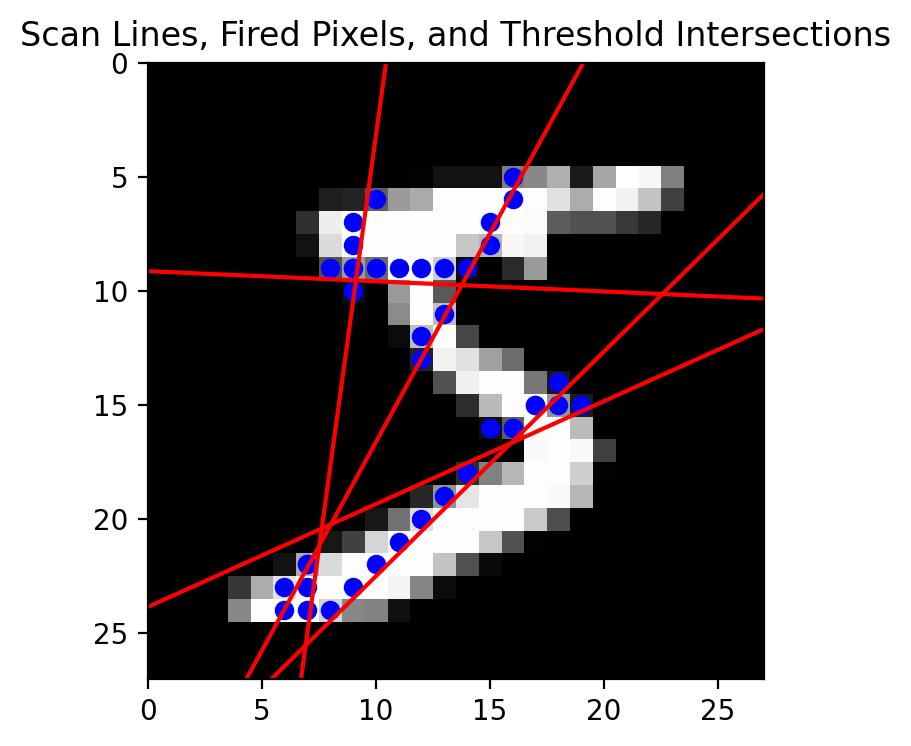

In [ ]:
def plot_scan_lines_fired_pixels_threshold(image, line_eqs, threshold):
    """
    Plots the image, scan lines, fired pixels, and highlights intersections
    with pixels above the threshold.
    """

    # Find the fired pixels
    x_range = (0, 27)
    y_range = (0, 27)
    fired_pixels = find_fired_pixels_bres(line_eqs, x_range, y_range)

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(4, 4))

    # Plot the original image
    ax.imshow(image, cmap='gray')

    # Plot the scan lines
    for m, c in line_eqs:
        x_coords = np.array(x_range)
        y_coords = (m * x_coords + c)  # Adjust for y-inversion
        ax.plot(x_coords, y_coords, 'r-', label='Scan Lines')

    # Highlight fired pixels above the threshold
    for idx, x, y in fired_pixels:
        if image[y, x] > threshold:  # Assuming (y, x) format for image
            ax.scatter(x, y, marker='o', color='blue', label='Fired Pixels')

    # Set axis limits and labels
    ax.set_xlim(0, 27)
    ax.set_ylim(0, 27)
    #ax.set_xlabel('X')
    #ax.set_ylabel('Y')
    ax.set_title('Scan Lines, Fired Pixels, and Threshold Intersections')
    plt.gca().invert_yaxis()
    plt.show()


# Example usage:

image = mnist.train_images()[0]  # Example MNIST image
threshold = 0.1  # Set your threshold value here
plot_scan_lines_fired_pixels_threshold(image, rand5_eqs, threshold)

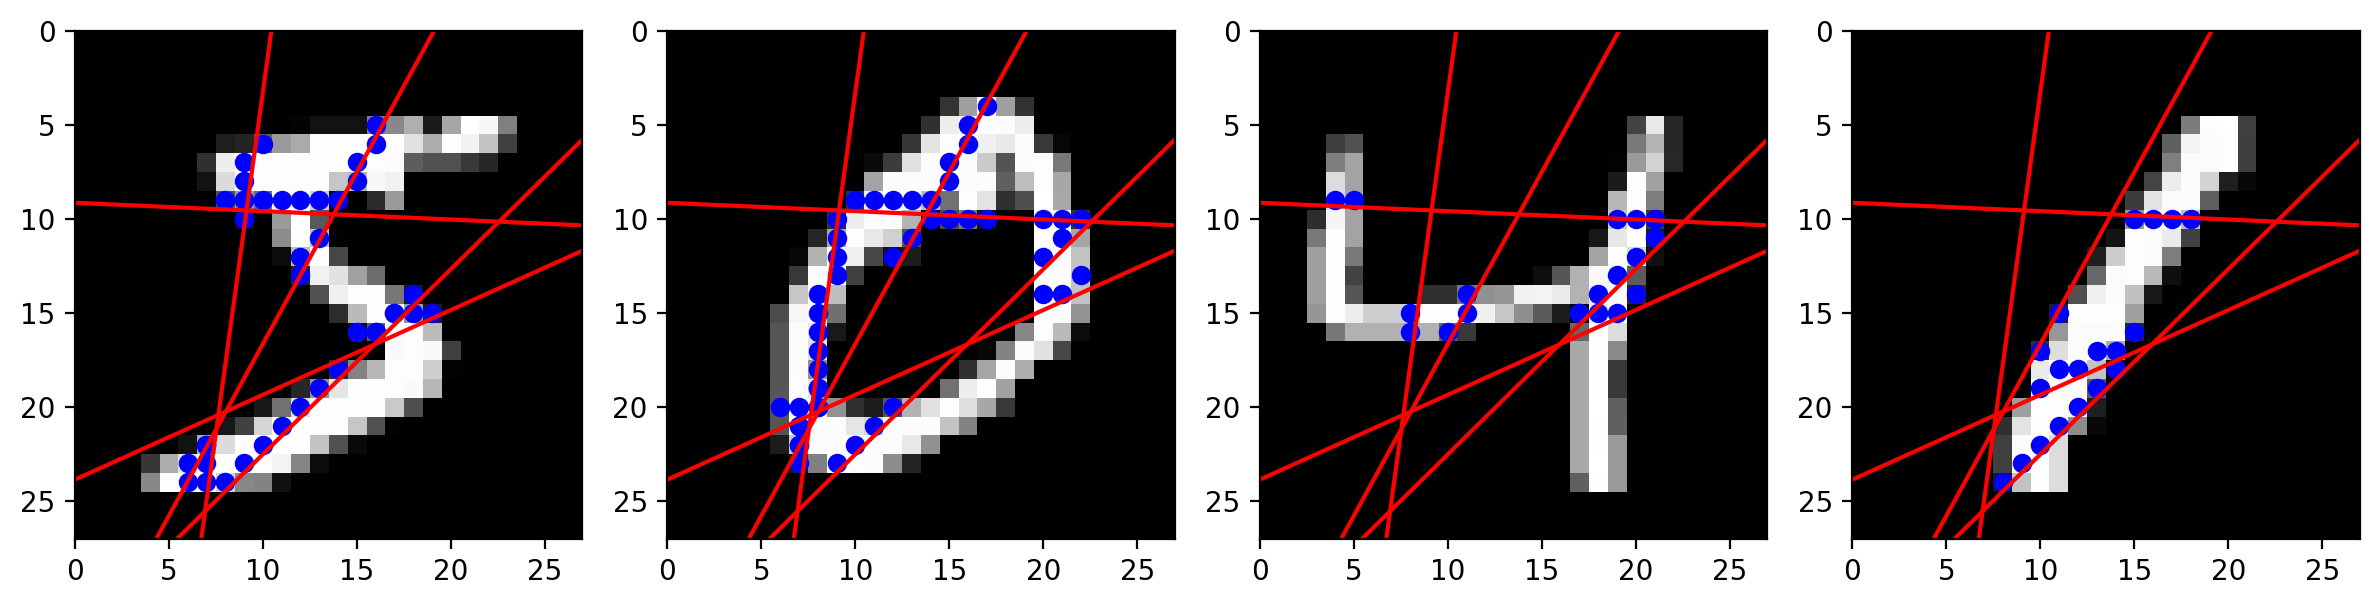

In [ ]:
def plot_scan_lines_fired_pixels_threshold(images, line_eqs, threshold):
    """
    Plots three images, scan lines, fired pixels, and highlights intersections
    with pixels above the threshold, arranged horizontally.
    """

    # Create the figure and axes
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))  # 1 row, 3 columns

    # Iterate through images and plot
    for i, image in enumerate(images):
        # Find the fired pixels
        x_range = (0, 27)
        y_range = (0, 27)
        fired_pixels = find_fired_pixels_bres(line_eqs, x_range, y_range)

        # Plot the original image
        axes[i].imshow(image, cmap='gray')

        # Plot the scan lines
        for m, c in line_eqs:
            x_coords = np.array(x_range)
            y_coords = (m * x_coords + c)  # Adjust for y-inversion
            axes[i].plot(x_coords, y_coords, 'r-', label='Scan Lines')

        # Highlight fired pixels above the threshold
        for idx, x, y in fired_pixels:
            if image[y, x] > threshold:  # Assuming (y, x) format for image
                axes[i].scatter(x, y, marker='o', color='blue', label='Fired Pixels')

        # Set axis limits and labels
        axes[i].set_xlim(0, 27)
        axes[i].set_ylim(0, 27)
        #axes[i].set_title(f'Image {i + 1}')  # Set title for each subplot

        # Invert y-axis for the current axes
        axes[i].invert_yaxis()

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

# Example usage:
images = mnist.train_images()[:4]  # Get the first 3 images
threshold = 0.1  # Set your threshold value here
plot_scan_lines_fired_pixels_threshold(images, rand5_eqs, threshold)

In [ ]:
image[7, 9]

189

In [ ]:
x_range = (-28, 28)
y_range = (-28, 28)
fired_pixels = find_fired_pixels_adj(rand5_eqs, x_range, y_range)
fired_pixels
image = mnist_train[0]
fired_pixs = []
for idx,x, y in fired_pixels:
  if image[y, x] > threshold:  # Assuming (y, x) format for image
      fired_pixs.append([x,y])
      plt.scatter(x, y, marker='o', color='blue', label='Fired Pixels')
      plt.xlim(0, 28)
      plt.ylim(0, 28)
      plt.gca().invert_yaxis()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
#fired_pixels

In [ ]:
def base_scanline_encoder(data,input_line_eqs,foveat):


  x_range = (-1, 29)
  y_range = (-1, 29)
  spikes=[]
  if foveat == 'yes':
    fired_pixels = find_fired_pixels_adj(input_line_eqs, x_range, y_range)
  else:
    fired_pixels = find_fired_pixels_bres(input_line_eqs, x_range, y_range)

  for img in data:
    #print(img)
    image = img
    fired_pixs = []
    for idx2, x, y in fired_pixels:
      if image[y, x] > 0:
        fired_pixs.append([x,y])

    mask = np.zeros_like(image,dtype=float)  #
    mask2 = np.zeros_like(image)

    for idx, (x, y) in enumerate(fired_pixs):
        mask[y, x] = float(int(idx))/2 +0.1
        mask2[y, x] = 1

    end_spikes=np.cumsum(mask2).flatten().tolist()


    last_num=0
    #plt.imshow(mask)
    spike_times=[]
    for num in mask.flatten():
      if last_num != num and num!=0:
        spike_times.append(num)
        last_num=num

    spikes.append(PreprocessedSpikes(np.array(end_spikes), np.array(spike_times)))
  return spikes



check=base_scanline_encoder(mnist_train[:200],rand5_eqs,'yes')
  #mask.flatten()

In [ ]:
#len(check[0][0])

784

In [ ]:
#loihi_train[0]

In [ ]:

#rand50_train=base_scanline_encoder(mnist_train,rand50_eqs)


# Gardner Scanline

In [ ]:

def find_last_occurrence(data, target):
  """Finds the last occurrence of a target value in an ordered list.

  Args:
    data: The ordered list to search.
    target: The value to search for.

  Returns:
    The index of the last occurrence of the target value, or -1 if not found.
  """
  last_index = -1  # Initialize to -1 to indicate not found
  for i in range(len(data)):
    if data[i] == target:
      last_index = i  # Update last_index whenever target is found
  return last_index  # Return the final last_index

def gard_scanline_encoder(data,input_line_eqs,num,foveat):
  x_range = (-1, 29)
  y_range = (-1, 29)
  spikes=[]
  if foveat == 'yes':
    fired_pixels = find_fired_pixels_adj(input_line_eqs, x_range, y_range)
  else:
    fired_pixels = find_fired_pixels_bres(input_line_eqs, x_range, y_range)

  fired_pixels = find_fired_pixels_bres(input_line_eqs, x_range, y_range)
  spike_times_final2 = []
  base_neurons=[]
  for i in range(num):
    base_neurons.append(i+1)

  for img in data:

    image = img
    fired_pixs = []

    for idx2, x, y in fired_pixels:
      if image[y, x] > 0:
        fired_pixs.append([idx2,x,y])


    mask3 = np.zeros_like(image)

    for idx, (idx2,x, y) in enumerate(fired_pixs):
        mask3[y,x] = idx2+1

    flattened_mask3 = mask3.flatten()
    num_periods = len(flattened_mask3) // 56  # Calculate the number of periods
    result = []
    #print(flattened_mask3)
    for i in range(num_periods+1):
      start_index = i * 56
      end_index = start_index + 56
      period_values = flattened_mask3[start_index:end_index]  # Get values for the current period
      unique_values = set(period_values)  # Convert to a set to get unique values
      unique_values.discard(0)  # Remove 0 from the set
      result.append([i,unique_values])  # Add the set to the result list

    spike_times_final = []
    neuron_ids_final = []


    for spike_time, neuron_id_set in result:
        #COUNTER=0
        for neuron_id in neuron_id_set:

            #if COUNTER < 5:
            spike_times_final.append(spike_time*4)
            neuron_ids_final.append(neuron_id)
            #COUNTER +=1

    # Zip the lists into a list of tuples
    zipped_list = list(zip(spike_times_final, neuron_ids_final))

    # Sort the list of tuples by neuron_ids_final (second element)
    ordered_list = sorted(zipped_list, key=lambda item: item[1])

    # Unzip the ordered list back into separate lists if needed
    spike_times_ordered, neuron_ids_ordered = zip(*ordered_list)


    last=1
    neuron_ids_ordered2=[]
    #print(base_neurons)
    for i in base_neurons:
      #
      value=find_last_occurrence(neuron_ids_ordered,i)
      #print(value)
      if i == 1:
        if value == -1:
          neuron_ids_ordered2.append(0)
        else:
          neuron_ids_ordered2.append(value)
      elif value == -1:
        neuron_ids_ordered2.append(last)
      else:
        neuron_ids_ordered2.append(value+1)
        last = value+1
    #print(neuron_ids_ordered)
    #print(neuron_ids_ordered2,len(spike_times_ordered))


    spike_times_final2.append(PreprocessedSpikes(np.array(neuron_ids_ordered2), np.array(spike_times_ordered)))
    #plt.scatter(spike_times_ordered,neuron_ids_ordered)
    #print(neuron_ids_ordered2,spike_times_ordered,neuron_ids_ordered)
  return spike_times_final2

#loihi_train=gard_scanline_encoder(mnist_train,rand5_eqs,5)

[4, 11, 13, 14, 21] (14, 18, 20, 22, 24, 6, 8, 10, 20, 22, 24, 14, 16, 8, 4, 6, 8, 10, 12, 22, 24) (1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5)


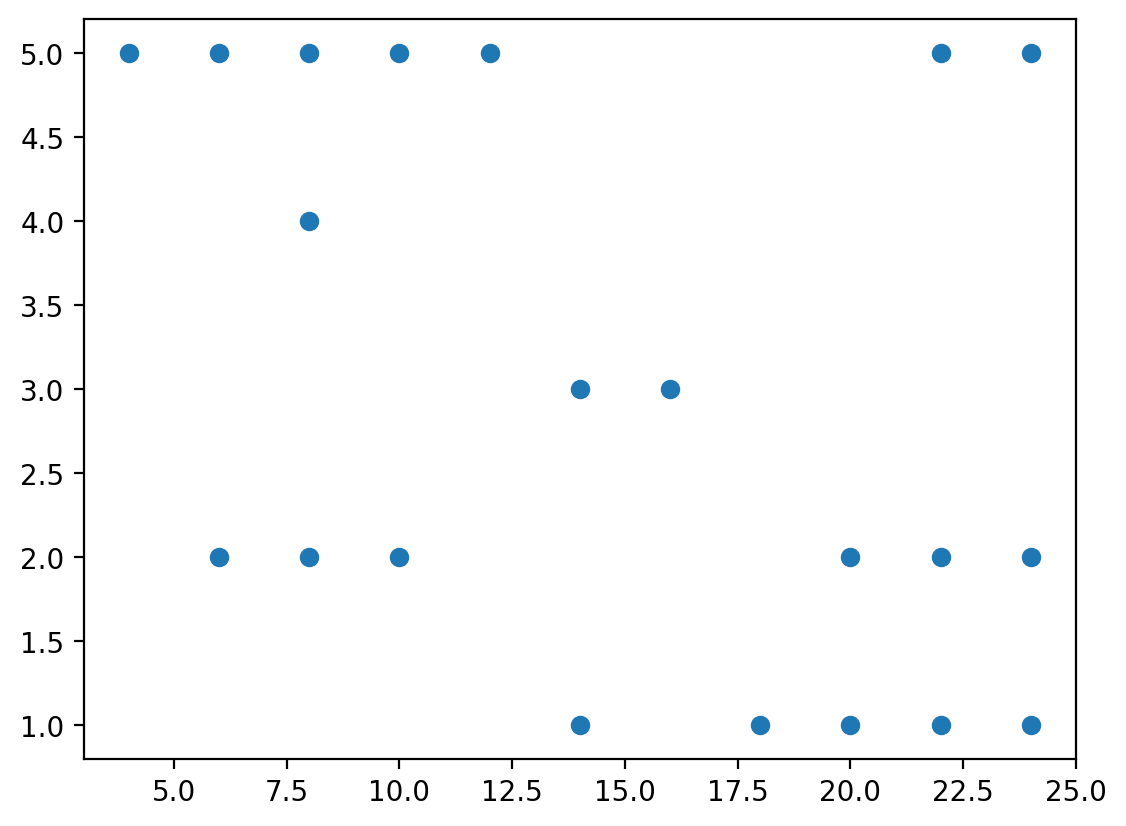

In [ ]:
spikeys=gard_scanline_encoder(mnist_train[:1],rand5_eqs,5,'yes')


ValueError: x and y must be the same size

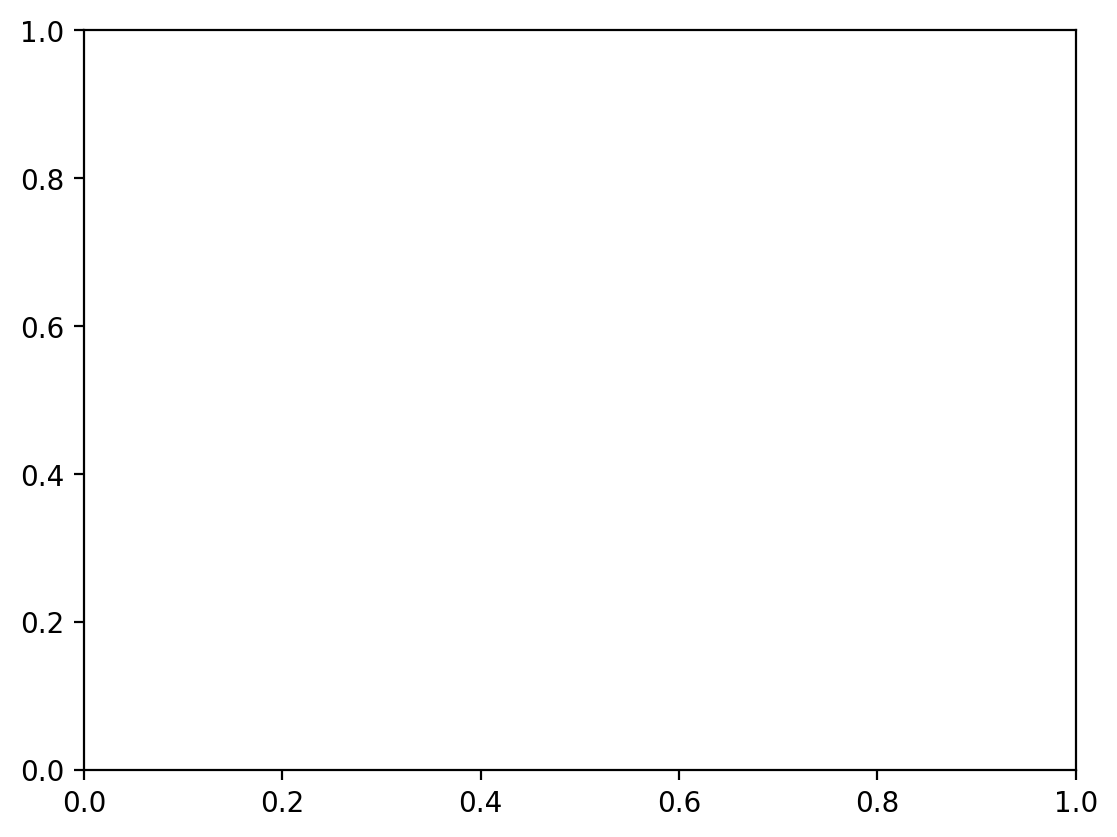

In [ ]:
plt.scatter(spikeys[0][0], spikeys[0][1])
plt.show()

In [ ]:
for i in spikeys:
  print(i[0],len(i[1]))

[ 2  5  7  8 12 17 18 23 24 29 34 42 47 49 52] 52
[ 3  6  9 11 13 18 20 24 25 27 35 42 46 48 52] 52
[ 2  1  5  7  8 12 16 20 21 23 25 27 30 31 33] 33
[ 1  3  5  6  6  9 10 14 15 17 17 23 25 26 26] 26
[ 0  1  2  4  5 10 14 22 23 26 31 36 40 42 45] 45
[ 3  6 10 12 16 19 21 25 27 32 39 48 54 56 60] 60
[ 0  1  1  2  2  4  7 15 16 19 19 23 27 28 28] 28
[ 4  6  9 11 16 21 24 31 32 35 43 51 58 60 63] 63
[ 0  1  1  1  1  2  4  7  8 11 11 14 17 18 18] 18
[ 4  1  7  8  9 14 16 18 19 23 26 31 35 37 39] 39
[ 2  4  7  8 10 14 15 22 23 27 31 39 46 48 49] 49
[ 1  1  4  5  5  8  9 11 12 14 16 20 21 23 24] 24
[ 3  5  7  8  9 13 18 27 29 36 40 49 57 59 61] 61
[ 2  5  9 10 14 17 21 26 27 31 37 46 51 53 55] 55
[ 0  1  2  2  2  3  4  5  6  9  9 13 17 19 19] 19
[ 4  6  9 11 11 16 19 24 25 28 32 35 39 41 45] 45
[ 3  6 10 12 16 18 20 24 25 28 34 40 46 48 52] 52
[ 1  3  5  7 10 15 16 21 22 26 33 43 47 49 49] 49
[ 0  1  3  4  9 11 13 18 19 22 22 31 36 38 38] 38
[ 1  1  3  5  5  9 10 15 16 19 19 26 29 31 31] 31


In [ ]:
del max_value
del max_time
del max

In [ ]:
max_value = 0
max_time = 0
for i in spikeys:
    #print(max(i[0]), max(i[1]))  # Use the built-in 'max' function here
    if max(i[0]) > max_value:
        max_value = max(i[0])
    if max(i[1]) > max_time:
        max_time = max(i[1])

print(max_value, max_time)  # Print the maximum values


55 13


## Network definition
Because our network is entirely feedforward, we can define it as a ``SequentialNetwork`` where each layer is automatically connected to the previous layer. As we have converted the MNIST dataset to spikes, we will use a ``SpikeInput`` to inject these directly into the network. For our hidden layer we are going to use standard Leaky integrate-and-fire neurons as this task does not require more computationally expensive adaptive LIF neurons. Finally, we are going to use a non-spiking output layer and read classifications out of this by determining the maximum of the summed membrane voltages of the output neurons.




##Parameters

Define some model parameters


In [ ]:
#NUM_INPUT = 28 * 28
NUM_INPUT = 784
NUM_HIDDEN = 128
NUM_OUTPUT = 10
BATCH_SIZE = 128

max_spikes_in_data = max(max(len(example.end_spikes), len(example.spike_times))
                        for example in loihi_train)

max_spikes = max(max_spikes_in_data, BATCH_SIZE * NUM_INPUT)

In [ ]:
# Create sequential model
serialiser = Numpy("latency_mnist_checkpoints")
network = SequentialNetwork(default_params)
with network:
    # Populations
    input = InputLayer(SpikeInput(max_spikes=10000000),  ## hardcode jesus
                                  NUM_INPUT,record_spikes=True)

    hidden = Layer(Dense(Normal(sd=1.0 / np.sqrt(NUM_INPUT))),
                   LeakyIntegrateFire(v_thresh=0.61, tau_mem=20.0,
                                      tau_refrac=5.0),
                   NUM_HIDDEN)
    output = Layer(Dense(Normal(sd=1.0 / np.sqrt(NUM_HIDDEN))),
                   LeakyIntegrate(tau_mem=20.0, readout="sum_var"),
                   NUM_OUTPUT)

## Compilation
In mlGeNN, in order to turn an abstract network description into something that can actually be used for training or inference you use a *compiler* class. Here, we use the ``EPropCompiler`` to train with e-prop and specify batch size and how many timesteps to evaluate each example for as well as choosing our optimiser and loss function. Because this is a classification task, we want to use cross-entropy loss and, because our labels are specified in this way (rather than e.g. one-hot encoded), we use the sparse catgorical variant.

In [ ]:
max_example_timesteps = int(np.ceil(calc_latest_spike_time(train_spikes)))
#max_example_timesteps=5
compiler = EPropCompiler(example_timesteps=max_example_timesteps,
                         losses="sparse_categorical_crossentropy",
                         optimiser="adam", batch_size=BATCH_SIZE)
compiled_net = compiler.compile(network)

## Training
Now we will train the model for 10 epochs using our compiled network. To verify it's performance we take 10% of the training data as a validation split and add an additional callback to checkpoint weights every epoch.



In [ ]:
with compiled_net:
    # Evaluate model on numpy dataset
    callbacks = ["batch_progress_bar", Checkpoint(serialiser)]
    compiled_net.train({input: train_spikes},
                       {output: mnist.train_labels()},
                       num_epochs=5, shuffle=True,
                       validation_split=0.1,
                       callbacks=callbacks)

RuntimeError: Nested compiled networks are not currently supported

In [ ]:
test_spikes = log_latency_encode_data(mnist.test_images(), 20.0, 51)

In [ ]:
network.load((5-1,), serialiser)
compiler = InferenceCompiler(evaluate_timesteps=max_example_timesteps,
                            batch_size=BATCH_SIZE)
compiled_net = compiler.compile(network)



callbacks = ["batch_progress_bar", SpikeRecorder(input, key="spikes_input")]
with compiled_net:
  metrics, cb_data = compiled_net.evaluate({input: test_spikes},
                                        {output: mnist.test_labels()},
                                        #{output: "mean_square_error", output_2: "sparse_categorical_accuracy"},
                                        callbacks=callbacks)

RuntimeError: Nested compiled networks are not currently supported

In [ ]:
#0.9645 # 50


## Evaluate
Load weights checkpointed from last epoch:

In [ ]:
network.load((49,), serialiser)

Create an ``InferenceCompiler`` and compile network for inference:

In [ ]:
compiler = InferenceCompiler(evaluate_timesteps=max_example_timesteps,
                             batch_size=BATCH_SIZE)
compiled_net = compiler.compile(network)

Encode *test set* using the same log-latency encoding and evaluate it:

In [ ]:
#test_spikes = log_latency_encode_data(mnist.test_images(), 20.0, 51)
test_spikes = loihi_encode(mnist.test_images(),line_eqs_loihi)
with compiled_net:
    compiled_net.evaluate({input: test_spikes},
                          {output: mnist.test_labels()})

In [ ]:
from ml_genn.callbacks import SpikeRecorder

callbacks = ["batch_progress_bar", SpikeRecorder(input, key="spikes_input")]
with compiled_net:
  metrics, cb_data = compiled_net.evaluate({input: test_spikes},
                                         {output: mnist.test_labels()},
                                         callbacks=callbacks)


In [ ]:
spike_times = cb_data["spikes_input"][0][0],
spike_ids = cb_data["spikes_input"][1][0]

plt.scatter(spike_times, spike_ids)
plt.show()

# Final Experiments


In [ ]:
mnist_train=mnist.train_images()
mnist_test=mnist.test_images()

In [ ]:
## Basic Scanlines
loihi_train=base_scanline_encoder(mnist_train,line_eqs_loihi,'no')
rand5_train=base_scanline_encoder(mnist_train,rand5_eqs,'no')
rand10_train=base_scanline_encoder(mnist_train,rand10_eqs,'no')
rand15_train=base_scanline_encoder(mnist_train,rand15_eqs,'no')
rand20_train=base_scanline_encoder(mnist_train,rand20_eqs,'no')
## Gardner Scanlines
g_loihi_train=gard_scanline_encoder(mnist_train,line_eqs_loihi,5,'no')
g_rand5_train=gard_scanline_encoder(mnist_train,rand5_eqs,5,'no')
g_rand10_train=gard_scanline_encoder(mnist_train,rand10_eqs,10,'no')
g_rand15_train=gard_scanline_encoder(mnist_train,rand15_eqs,15,'no')
g_rand20_train=gard_scanline_encoder(mnist_train,rand20_eqs,20,'no')
## Basic Scanlines
loihi_test=base_scanline_encoder(mnist_test,line_eqs_loihi,'no')
rand5_test=base_scanline_encoder(mnist_test,rand5_eqs,'no')
rand10_test=base_scanline_encoder(mnist_test,rand10_eqs,'no')
rand15_test=base_scanline_encoder(mnist_test,rand15_eqs,'no')
rand20_test=base_scanline_encoder(mnist_test,rand20_eqs,'no')
## Gardner Scanlines
g_loihi_test=gard_scanline_encoder(mnist_test,line_eqs_loihi,5,'no')
g_rand5_test=gard_scanline_encoder(mnist_test,rand5_eqs,5,'no')
g_rand10_test=gard_scanline_encoder(mnist_test,rand10_eqs,10,'no')
g_rand15_test=gard_scanline_encoder(mnist_test,rand15_eqs,15,'no')
g_rand20_test=gard_scanline_encoder(mnist_test,rand20_eqs,20,'no')

In [ ]:
###foveated
## Basic Scanlines
loihi_train_fov=base_scanline_encoder(mnist_train,line_eqs_loihi,'yes')
rand5_train_fov=base_scanline_encoder(mnist_train,rand5_eqs,'yes')
rand10_train_fov=base_scanline_encoder(mnist_train,rand10_eqs,'yes')
rand15_train_fov=base_scanline_encoder(mnist_train,rand15_eqs,'yes')
rand20_train_fov=base_scanline_encoder(mnist_train,rand20_eqs,'yes')
## Gardner Scanlines
g_loihi_train_fov=gard_scanline_encoder(mnist_train,line_eqs_loihi,5,'yes')
g_rand5_train_fov=gard_scanline_encoder(mnist_train,rand5_eqs,5,'yes')
g_rand10_train_fov=gard_scanline_encoder(mnist_train,rand10_eqs,10,'yes')
g_rand15_train_fov=gard_scanline_encoder(mnist_train,rand15_eqs,15,'yes')
g_rand20_train_fov=gard_scanline_encoder(mnist_train,rand20_eqs,20,'yes')
## Basic Scanlines
loihi_test_fov=base_scanline_encoder(mnist_test,line_eqs_loihi,'yes')
rand5_test_fov=base_scanline_encoder(mnist_test,rand5_eqs,'yes')
rand10_test_fov=base_scanline_encoder(mnist_test,rand10_eqs,'yes')
rand15_test_fov=base_scanline_encoder(mnist_test,rand15_eqs,'yes')
rand20_test_fov=base_scanline_encoder(mnist_test,rand20_eqs,'yes')
## Gardner Scanlines
g_loihi_test_fov=gard_scanline_encoder(mnist_test,line_eqs_loihi,5,'yes')
g_rand5_test_fov=gard_scanline_encoder(mnist_test,rand5_eqs,5,'yes')
g_rand10_test_fov=gard_scanline_encoder(mnist_test,rand10_eqs,10,'yes')
g_rand15_test_fov=gard_scanline_encoder(mnist_test,rand15_eqs,15,'yes')
g_rand20_test_fov=gard_scanline_encoder(mnist_test,rand20_eqs,20,'yes')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
len(g_loihi_train)

60000

In [ ]:
from ml_genn.callbacks import SpikeRecorder

In [ ]:
def experiment(training_data,test_data,n_i,epoch_input):
  #NUM_INPUT = 28 * 28
  NUM_INPUT = n_i
  NUM_HIDDEN = 128
  NUM_OUTPUT = 10
  BATCH_SIZE = 128

  # Create sequential model

  serialiser = Numpy("latency_mnist_checkpoints")
  network = SequentialNetwork(default_params)
  with network:
      # Populations
      input = InputLayer(SpikeInput(max_spikes=10000000),  ## hardcode jesus
                                    NUM_INPUT,record_spikes=True)

      hidden = Layer(Dense(Normal(sd=1.0 / np.sqrt(NUM_INPUT))),
                    LeakyIntegrateFire(v_thresh=0.61, tau_mem=20.0,
                                        tau_refrac=5.0),
                    NUM_HIDDEN)
      output = Layer(Dense(Normal(sd=1.0 / np.sqrt(NUM_HIDDEN))),
                    LeakyIntegrate(tau_mem=20.0, readout="sum_var"),
                    NUM_OUTPUT)
  max_example_timesteps = int(np.ceil(calc_latest_spike_time(training_data)))

  #max_example_timesteps=5
  compiler = EPropCompiler(example_timesteps=max_example_timesteps,
                          losses="sparse_categorical_crossentropy",
                          optimiser="adam", batch_size=BATCH_SIZE)
  compiled_net = compiler.compile(network)

  with compiled_net:
      # Evaluate model on numpy dataset
      callbacks = ["batch_progress_bar", Checkpoint(serialiser)]
      compiled_net.train({input: training_data},
                        {output: mnist.train_labels()},
                        num_epochs=epoch_input, shuffle=True,
                        validation_split=0.1,
                        callbacks=callbacks)

  network.load((epoch_input-1,), serialiser)
  compiler = InferenceCompiler(evaluate_timesteps=max_example_timesteps,
                             batch_size=BATCH_SIZE)
  compiled_net = compiler.compile(network)



  callbacks = ["batch_progress_bar", SpikeRecorder(input, key="spikes_input")]
  with compiled_net:
    metrics, cb_data = compiled_net.evaluate({input: test_data},
                                          {output: mnist.test_labels()},
                                          #{output: "mean_square_error", output_2: "sparse_categorical_accuracy"},
                                          callbacks=callbacks)
    sca=metrics[output].result
    #sca=metrics[output_2].result


  return sca, cb_data



In [ ]:
loihi_results,loise_out_data=experiment(loihi_train,loihi_test,784,5)
print(loihi_results)
rand5_results,rand5_out_data=experiment(rand5_train,rand5_test,784,5)
print(rand5_results)
rand10_results,rand10_out_data=experiment(rand10_train,rand10_test,784,5)
print(rand10_results)
rand15_results,rand15_out_data=experiment(rand15_train,rand15_test,784,5)
print(rand15_results)
rand20_results,rand20_out_data=experiment(rand20_train,rand20_test,784,5)
print(rand20_results)
g_loihi_results,g_loihi_out_data=experiment(g_loihi_train,g_loihi_test,5,5)
print(g_loihi_results)
g_rand5_results,g_rand5_out_data=experiment(g_rand5_train,g_rand5_test,5,5)
print(g_rand5_results)
g_rand10_results,g_rand10_out_data=experiment(g_rand10_train,g_rand10_test,10,5)
print(g_rand10_results)
g_rand15_results,g_rand15_out_data=experiment(g_rand15_train,g_rand15_test,15,5)
print(g_rand15_results)
g_rand20_results,g_rand20_out_data=experiment(g_rand20_train,g_rand20_test,20,5)
print(g_rand20_results)

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.7698


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.8253


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.8898


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.8911


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9026


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.184


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.1976


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.2392


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.3021


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.2267


In [ ]:
rand5_results,rand5_out_data=experiment(rand5_train,rand5_test,784,5)
print(rand5_results)
rand10_results,rand10_out_data=experiment(rand10_train,rand10_test,784,5)
print(rand10_results)
rand15_results,rand15_out_data=experiment(rand15_train,rand15_test,784,5)
print(rand15_results)
rand20_results,rand20_out_data=experiment(rand20_train,rand20_test,784,5)
print(rand20_results)
rand5_results,rand5_out_data=experiment(rand5_train,rand5_test,784,100)
print(rand5_results)
rand10_results,rand10_out_data=experiment(rand10_train,rand10_test,784,100)
print(rand10_results)
rand15_results,rand15_out_data=experiment(rand15_train,rand15_test,784,100)
print(rand15_results)
rand20_results,rand20_out_data=experiment(rand20_train,rand20_test,784,100)
print(rand20_results)

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.8298


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.8915


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.8917


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9023


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.8267


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9255


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9383


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.9412


In [ ]:

g_loihi_results,g_loihi_out_data=experiment(g_loihi_train,g_loihi_test,5,100)
print(g_loihi_results)
g_rand5_results,g_rand5_out_data=experiment(g_rand5_train,g_rand5_test,5,100)
print(g_rand5_results)
g_rand10_results,g_rand10_out_data=experiment(g_rand10_train,g_rand10_test,10,100)
print(g_rand10_results)
g_rand15_results,g_rand15_out_data=experiment(g_rand15_train,g_rand15_test,15,100)
print(g_rand15_results)
g_rand20_results,g_rand20_out_data=experiment(g_rand20_train,g_rand20_test,20,100)
print(g_rand20_results)

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.4023


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.512


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.659


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.7413


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.7459


In [ ]:

g_rand5_results,g_rand5_out_data=experiment(g_rand5_train,g_rand5_test,5,5)
print(g_rand5_results)
g_rand10_results,g_rand10_out_data=experiment(g_rand10_train,g_rand10_test,10,5)
print(g_rand10_results)
g_rand15_results,g_rand15_out_data=experiment(g_rand15_train,g_rand15_test,15,5)
print(g_rand15_results)
g_rand20_results,g_rand20_out_data=experiment(g_rand20_train,g_rand20_test,20,5)
print(g_rand20_results)

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.5235


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.6461


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.748


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.7394


In [ ]:
g_rand15_results16,g_rand15_out_data16=experiment(g_rand15_train,g_rand15_test,15,100)
print(g_rand15_results)

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

0.748


In [ ]:
g_rand5_results16,g_rand5_out_data16=experiment(g_rand5_train,g_rand5_test,5,1600)
print(g_rand15_results)

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

KeyboardInterrupt: 

NameError: name 'g_loihi_results' is not defined

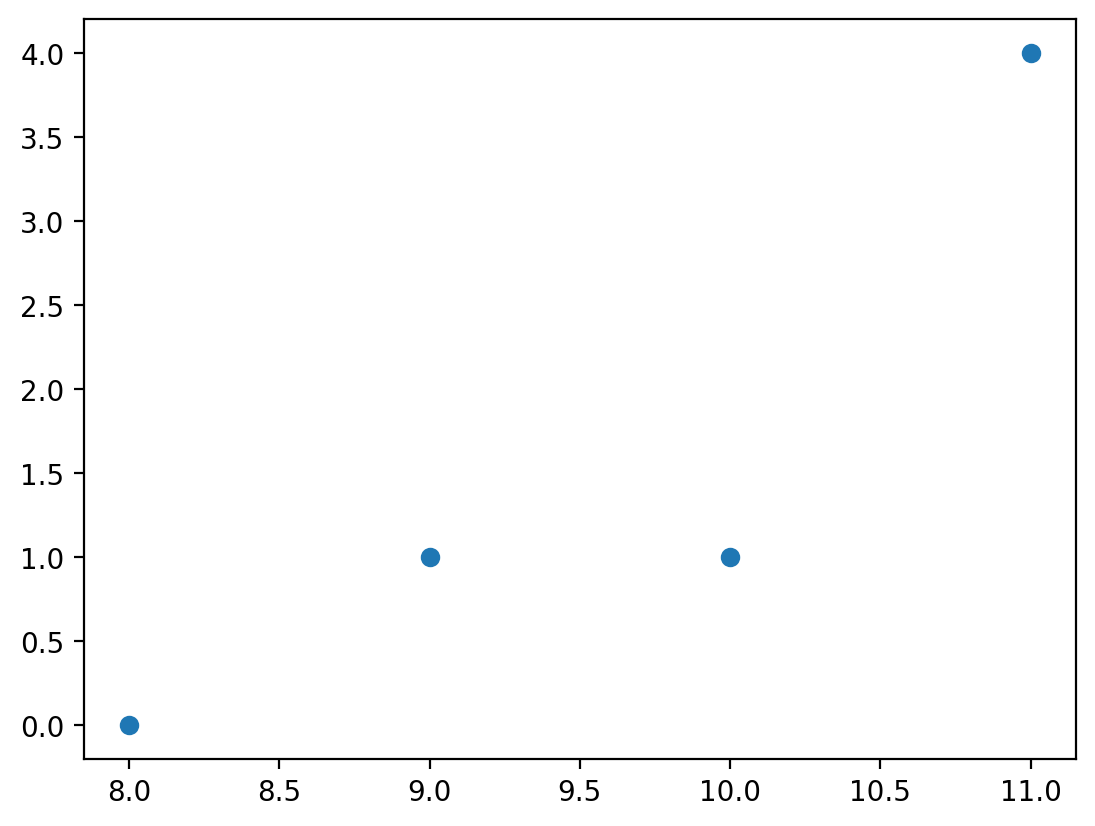

In [ ]:
spike_times = g_loihi_out_data["spikes_input"][0][2],
spike_ids = g_loihi_out_data["spikes_input"][1][2]

plt.scatter(spike_times, spike_ids)
plt.show()

In [ ]:
spike_times

(array([  2.,   3.,   4.,   5.,   6.,   6.,   6.,   8.,   8.,   9.,   9.,
          9.,   9.,  10.,  10.,  10.,  10.,  11.,  11.,  11.,  12.,  12.,
         12.,  13.,  13.,  13.,  14.,  14.,  15.,  15.,  16.,  16.,  17.,
         17.,  18.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,
         27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,
         38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,
         49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,
         71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,
         82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,
         93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
        104., 105., 106., 107., 108., 109., 110., 111., 112., 113., 114.,
        115., 116., 117., 118., 119., 120., 121., 122., 123., 124., 125.,
        126.]),)

In [ ]:
g_loihi_test[0]

PreprocessedSpikes(end_spikes=array([ 0,  6,  0,  8, 11]), spike_times=array([ 9,  3,  4,  5,  6,  7,  3,  4, 10, 11, 12]))